# Lag Correlation Analysis
In this file, we explore how anomaly in various time periods leading up to an outbreaks correlate with defoliation extent.

In [2]:
import matplotlib.patches as patches
import matplotlib.text as text
import matplotlib.pyplot as plt

# Standard library
import re

# Third party
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection
import ultraplot as uplt

## Parameters

In [3]:
max_length = 8 # Max window lendth to use.

# Labeling
min_corr = 0.1 # Minimum correlation for labeling
sig_choice = 'fdr' # Method for significance 'fdr' or 'raw'

# File name:
folder_path = './Figures/LagCorrelations/'
file_name = 'correlation_anomalies'
file_type = '.png'

file_path = (folder_path + file_name + 
             '_max_length_' + str(max_length) + 
             '_min_corr_' + str(min_corr).replace('.', '_') + 
             '_' + sig_choice + file_type)

## Combine anomaly files into one csv

In [ ]:
for year in [2020, 2021, 2022, 2023]:
    # Load all of the precipitation data and merge into one dataframe
    prcp_df = gpd.read_file(f'./Data/TimeImpacts/prcp_grid_{year}_month_1.geojson')
    for i in range(2, 25):
        temp_df = gpd.read_file(f'./Data/TimeImpacts/prcp_grid_{year}_month_{i}.geojson')
        prcp_df = prcp_df.merge(temp_df, how='inner', on='id', suffixes=(f'_{i-1}', f'_{i}'))
    prcp_df = prcp_df.drop(columns=[f'geometry_{i}' for i in range(1, 25)])
    
    # Load all of the precipitation data and merge into one dataframe
    tmax_df = gpd.read_file(f'./Data/TimeImpacts/tmax_grid_{year}_month_1.geojson')
    for i in range(2, 25):
        temp_df = gpd.read_file(f'./Data/TimeImpacts/tmax_grid_{year}_month_{i}.geojson')
        tmax_df = tmax_df.merge(temp_df, how='inner', on='id', suffixes=(f'_{i-1}', f'_{i}'))
    tmax_df = tmax_df.drop(columns=[f'geometry_{i}' for i in range(1, 25)])
    
    full_df = gpd.read_file(f'./Data/TimeImpacts/forest_grid_{year}.geojson')
    full_df = full_df.merge(prcp_df, how='inner', left_on='id', right_on='id')
    full_df = full_df.merge(tmax_df, how='inner', on='id')
    full_df = full_df.drop('id', axis=1)
    full_df['defol_forest_2'] = full_df['defoliation_2']/full_df['forest']
    full_df['defol_forest_mask_2'] = full_df['defoliation_2']/full_df['qa_mask_2']
    full_df['defol_forest_3'] = full_df['defoliation_3']/full_df['forest']
    full_df['defol_forest_mask_3'] = full_df['defoliation_3']/full_df['qa_mask_3']
    full_df.to_file(f'./Data/TimeImpacts/time_lags_months_{year}.geojson')

## Load Data

In [4]:
prcp_anom_cols = [f'prcp_anom_{i}' for i in range(1, 25)]
tmax_anom_cols = [f'tmax_anom_{i}' for i in range(1, 25)]
prcp_mean_cols = [f'prcp_mean_{i}' for i in range(1, 25)]
tmax_mean_cols = [f'tmax_mean_{i}' for i in range(1, 25)]

In [5]:
df_2021 = pd.read_csv('./Data/time_lags_months_2021.csv')

df_2023 = pd.read_csv('./Data/time_lags_months_2023.csv')

full_df = pd.concat([df_2021, df_2023], axis=0)

## Helper Functions

In [7]:
def get_corr(df, metric, cols, i, j):
    """Generates a tuple containing the start/end of 
       period of interest in # of months before
       defoliation, correlation of anomaly during this period
       with specified metric, and p-value for correlation."""
    df['temp'] = 0
    for k in range(i, j+1):
        df['temp'] += df[cols[k]]
    df_clean = df[['temp', metric]].dropna()
    corr = pearsonr(df_clean['temp'], df_clean[metric])
    return [i, j, corr[0], corr[1]]

## Plot correlation data

In [8]:
prcp_grid = np.zeros((max_length, 24))
prcp_sig = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        corr_tuple = get_corr(full_df, 'defol_forest_3', prcp_anom_cols, i, i+length)
        prcp_grid[length, 24-i-length-1] = corr_tuple[2]
        prcp_sig[length, 24-i-length-1] = corr_tuple[3]

if sig_choice == 'fdr':
    prcp_is_sig, qvalue = fdrcorrection(prcp_sig.reshape(-1), 
                                         alpha=0.05, method='indep', is_sorted=False)
    prcp_is_sig = prcp_is_sig.reshape((max_length, 24))
else:
    prcp_is_sig = prcp_sig <= 0.05

C:\Users\camer\AppData\Local\Temp\ipykernel_25640\2219470815.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['temp'] = 0


In [9]:
tmax_grid = np.zeros((max_length, 24))
tmax_sig = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        corr_tuple = get_corr(full_df, 'defol_forest_3', tmax_anom_cols, i, i+length)
        tmax_grid[length, 24-i-length-1] = corr_tuple[2]
        tmax_sig[length, 24-i-length-1] = corr_tuple[3]

if sig_choice == 'fdr':
    tmax_is_sig, qvalue = fdrcorrection(tmax_sig.reshape(-1), 
                                         alpha=0.05, method='indep', is_sorted=False)
    tmax_is_sig = tmax_is_sig.reshape((max_length, 24))
else:
    tmax_is_sig = tmax_sig <= 0.05

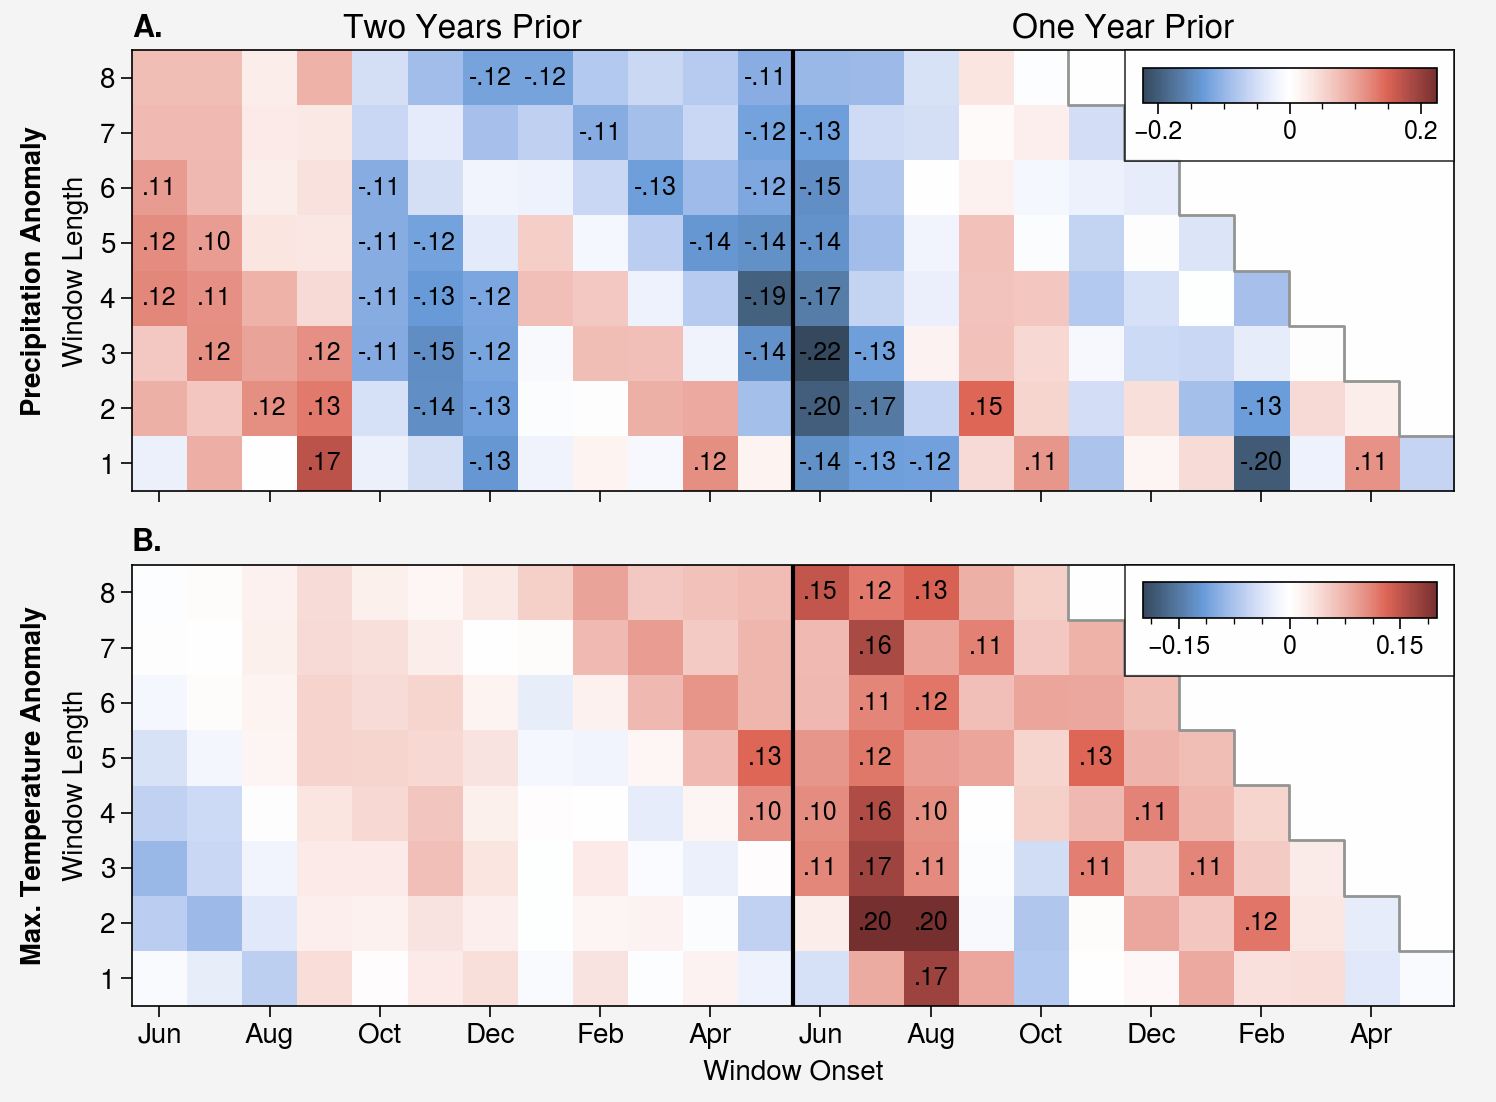

In [10]:
fig, axes = uplt.subplots(nrows=2, figsize=('190mm', '140mm'), sharey=False, fontsize=10)

# Plot correlation plots and add corresponding colorbars
vmax = np.max(np.abs(prcp_grid))
m = axes[0].imshow(prcp_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[0].colorbar(m, loc='ur', locator=[-0.2, 0, 0.2], length=11.75, width=1.4)

vmax = np.max(np.abs(tmax_grid))
m = axes[1].imshow(tmax_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[1].colorbar(m, loc='ur', locator=[-0.15, 0, 0.15], length=11.75, width=1.4)

axes.format(ylim=[-0.5,7.5], grid=False,
            xlocator=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
            xticklabels=['Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr']*2,
            xlabel='Window Onset',
            ylocator=list(range(8)),
            yticklabels=['1', '2', '3', '4', '5', '6', '7', '8'],
            ylabel='Window Length',
            leftlabels=['Precipitation Anomaly', 'Max. Temperature Anomaly'],
            abc='A.')

# Add right hand borders to separate 'nonsensical' regions
x = [16.5, 16.5, 17.5, 17.5, 18.5, 18.5, 19.5, 19.5, 
     20.5, 20.5, 21.5, 21.5, 22.5, 22.5, 23.5]
y = [7.5, 6.5, 6.5, 5.5, 5.5, 4.5, 4.5,
     3.5, 3.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5]
axes.plot(x, y, color='gray', linewidth=1)

# Add subtitles
axes[0].text(0.25, 1.05, 'Two Years Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

axes[0].text(0.75, 1.05, 'One Year Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

# Add Year Transition line to each plot
axes.axvline(11.5, color='black')

# Loop over data dimensions and create text annotations.
for i in range(max_length):
    for j in range(24):
        if prcp_is_sig[i,j] & (prcp_grid[i, j] != 0) & (np.abs(prcp_grid[i,j]) >= min_corr):
            axes[0].text(j, i, re.sub('0(?=[.])', '', f'{prcp_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

for i in range(max_length):
    for j in range(24):
        if (tmax_sig[i,j] <= 0.05) & (tmax_grid[i, j] != 0) & (np.abs(tmax_grid[i,j]) >= min_corr):
            axes[1].text(j, i, re.sub('0(?=[.])', '', f'{tmax_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

#fig.savefig(file_path)

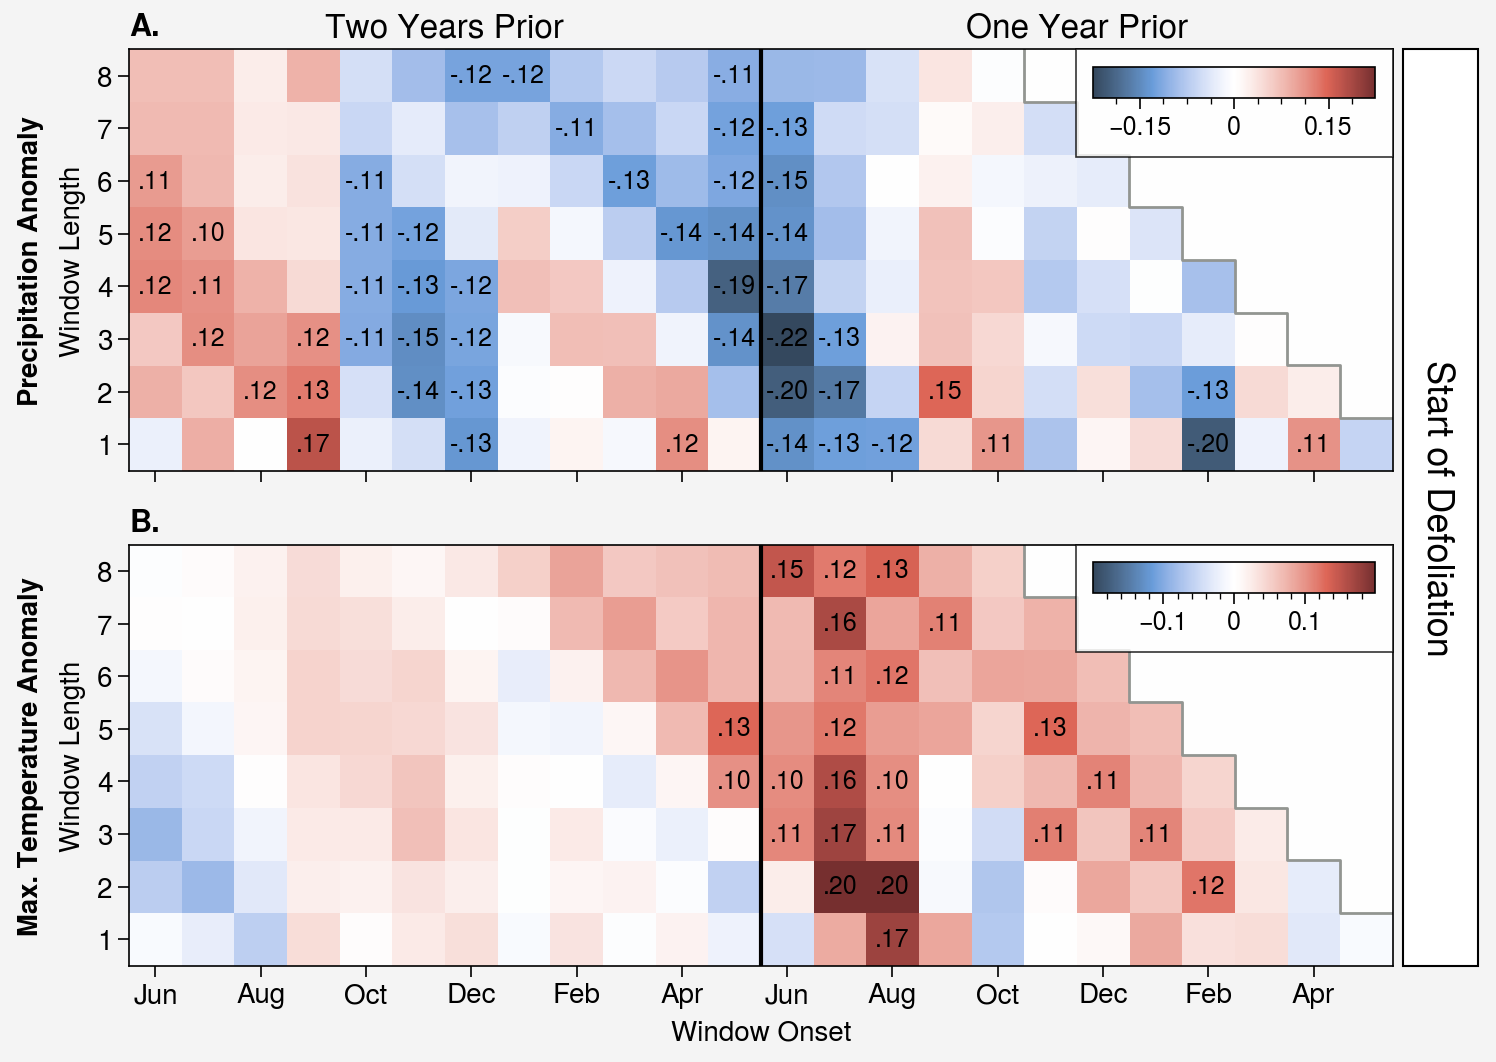

In [11]:
layout = [[1, 3], [2, 3]]
fig, axes = uplt.subplots(nrows=2, figsize=('190mm', '135mm'), sharey=False, fontsize=10)

# Plot correlation plots and add corresponding colorbars
vmax = np.max(np.abs(prcp_grid))
m = axes[0].imshow(prcp_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[0].colorbar(m, loc='ur', locator=[-0.15, 0, 0.15], length=11.25, width=1.25)

vmax = np.max(np.abs(tmax_grid))
m = axes[1].imshow(tmax_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[1].colorbar(m, loc='ur', locator=[-0.1, 0, 0.1], length=11.25, width=1.25)

axes[0:2].format(ylim=[-0.5,7.5], grid=False,
            xlocator=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
            xticklabels=['Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr']*2,
            xlabel='Window Onset',
            ylocator=list(range(8)),
            yticklabels=['1', '2', '3', '4', '5', '6', '7', '8'],
            ylabel='Window Length',
            leftlabels=['Precipitation Anomaly', 'Max. Temperature Anomaly'],
            abc='A.')

# Add right hand borders to separate 'nonsensical' regions
x = [16.5, 16.5, 17.5, 17.5, 18.5, 18.5, 19.5, 19.5, 
     20.5, 20.5, 21.5, 21.5, 22.5, 22.5, 23.5]
y = [7.5, 6.5, 6.5, 5.5, 5.5, 4.5, 4.5,
     3.5, 3.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5]
axes[0:2].plot(x, y, color='gray', linewidth=1)

# Add subtitles
axes[0].text(0.25, 1.05, 'Two Years Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

axes[0].text(0.75, 1.05, 'One Year Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

# Add Year Transition line to each plot
axes[0:2].axvline(11.5, color='black')

# Loop over data dimensions and create text annotations.
for i in range(max_length):
    for j in range(24):
        if prcp_is_sig[i,j] & (prcp_grid[i, j] != 0) & (np.abs(prcp_grid[i,j]) >= min_corr):
            axes[0].text(j, i, re.sub('0(?=[.])', '', f'{prcp_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

for i in range(max_length):
    for j in range(24):
        if (tmax_sig[i,j] <= 0.05) & (tmax_grid[i, j] != 0) & (np.abs(tmax_grid[i,j]) >= min_corr):
            axes[1].text(j, i, re.sub('0(?=[.])', '', f'{tmax_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

bbox_figure0 = axes[0].get_position()
bbox_figure1 = axes[1].get_position()
height = bbox_figure0.y1 - bbox_figure1.y0
# Create a Rectangle patch
rect = patches.Rectangle((bbox_figure1.x1-0.0185, bbox_figure1.y0+0.005), 0.05, height-0.0015, linewidth=0.75, 
                         edgecolor='black', facecolor='white', 
                         transform=fig.transFigure,  clip_on=False)
rect.set_in_layout(False)

# Add the patch to the Axes
axes[1].add_patch(rect)
t = text.Text(bbox_figure1.x1-0.0185+0.0225, bbox_figure1.y0+0.005 + (height-0.0015)/2, "Start of Defoliation",
              rotation=270, va='center', ha='center', fontsize=13,
              transform=fig.transFigure, clip_on=False)
t.set_in_layout(False)
axes[1].add_artist(t)
fig.savefig(file_path)

## Generate Figures with masking

In [25]:
max_length = 8 # Max window lendth to use.

# Labeling
min_corr = 0.1 # Minimum correlation for labeling
sig_choice = 'fdr' # Method for significance 'fdr' or 'raw'

# File name:
folder_path = './Figures/LagCorrelations/'
file_name = 'correlation_anomalies_masked'
file_type = '.png'

file_path = (folder_path + file_name + 
             '_max_length_' + str(max_length) + 
             '_min_corr_' + str(min_corr).replace('.', '_') + 
             '_' + sig_choice + file_type)

In [26]:
min_prop = 3/4
full_df['suf_obs'] = full_df['qa_mask_3']/full_df['forest'] >= min_prop

In [27]:
full_df_masked = full_df[full_df['suf_obs']].copy()

In [28]:
prcp_grid = np.zeros((max_length, 24))
prcp_sig = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        corr_tuple = get_corr(full_df_masked, 'defol_forest_3', prcp_anom_cols, i, i+length)
        prcp_grid[length, 24-i-length-1] = corr_tuple[2]
        prcp_sig[length, 24-i-length-1] = corr_tuple[3]

if sig_choice == 'fdr':
    prcp_is_sig, qvalue = fdrcorrection(prcp_sig.reshape(-1), 
                                         alpha=0.05, method='indep', is_sorted=False)
    prcp_is_sig = prcp_is_sig.reshape((max_length, 24))
else:
    prcp_is_sig = prcp_sig <= 0.05

In [29]:
tmax_grid = np.zeros((max_length, 24))
tmax_sig = np.zeros((max_length, 24))

for length in range(0, max_length):
    for i in range(0, 24-length):
        corr_tuple = get_corr(full_df_masked, 'defol_forest_3', tmax_anom_cols, i, i+length)
        tmax_grid[length, 24-i-length-1] = corr_tuple[2]
        tmax_sig[length, 24-i-length-1] = corr_tuple[3]

if sig_choice == 'fdr':
    tmax_is_sig, qvalue = fdrcorrection(tmax_sig.reshape(-1), 
                                         alpha=0.05, method='indep', is_sorted=False)
    tmax_is_sig = tmax_is_sig.reshape((max_length, 24))
else:
    tmax_is_sig = tmax_sig <= 0.05

Text(0.9601189984953069, 0.5213662893766117, 'Start of Defoliation')

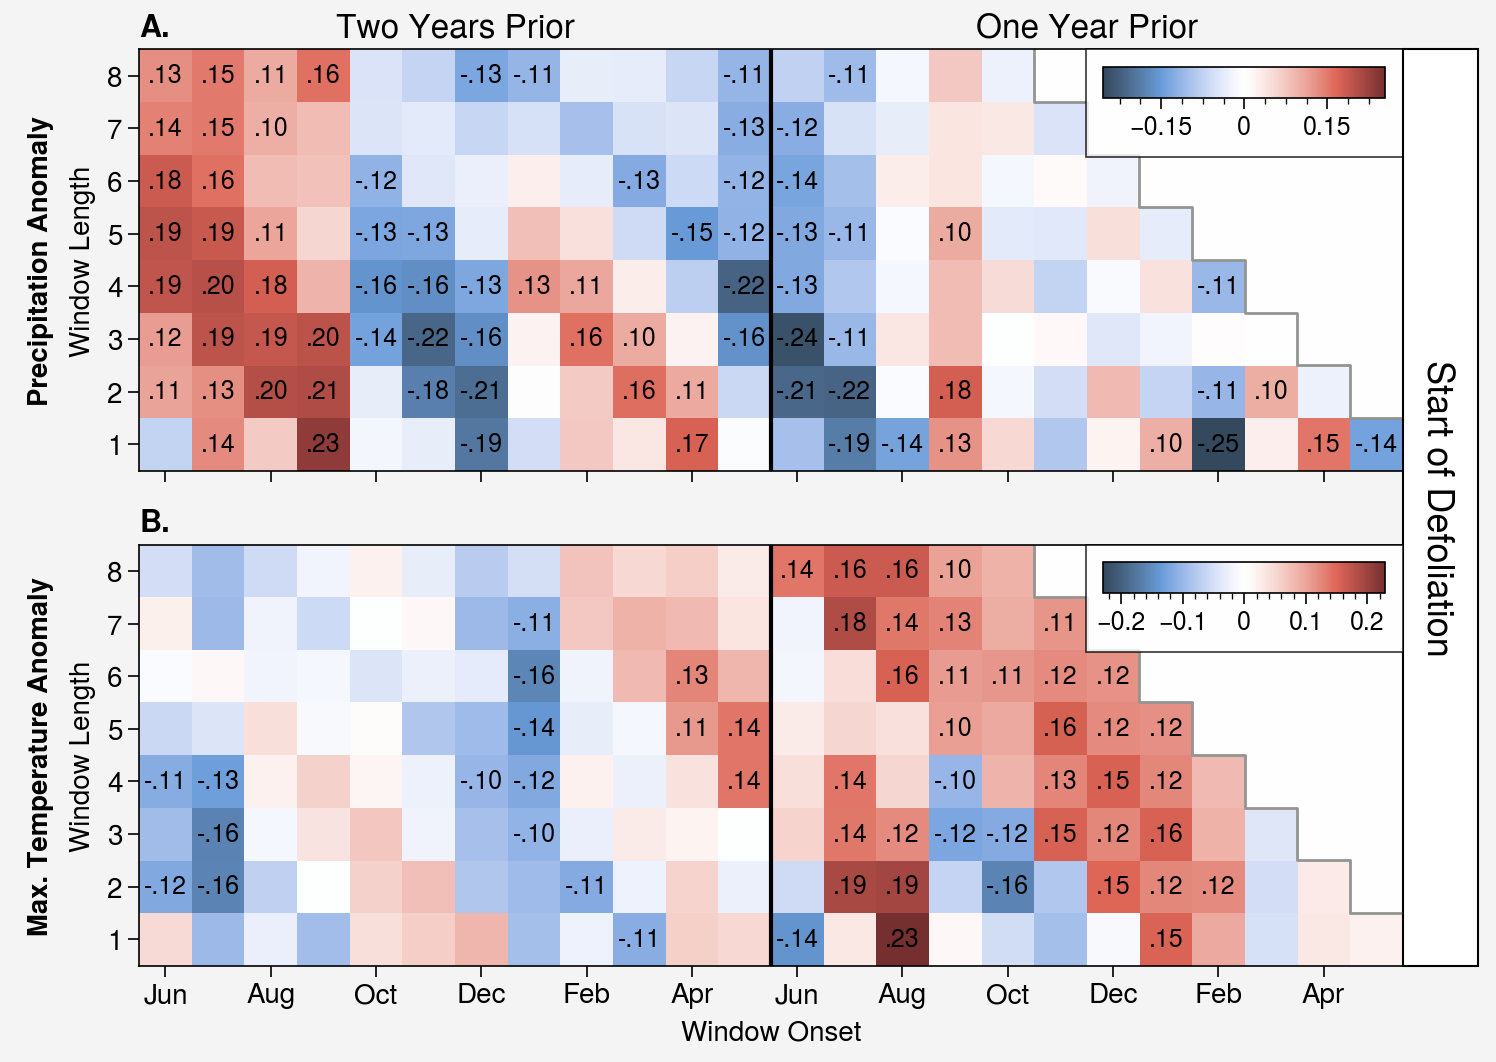

In [33]:
layout = [[1, 3], [2, 3]]
fig, axes = uplt.subplots(nrows=2, figsize=('190mm', '135mm'), sharey=False, fontsize=10)

# Plot correlation plots and add corresponding colorbars
vmax = np.max(np.abs(prcp_grid))
m = axes[0].imshow(prcp_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[0].colorbar(m, loc='ur', locator=[-0.15, 0, 0.15], length=11.25, width=1.25)

vmax = np.max(np.abs(tmax_grid))
m = axes[1].imshow(tmax_grid, cmap='NegPos', vmin=-vmax, vmax=vmax)
axes[1].colorbar(m, loc='ur', locator=[-0.2, -0.1, 0, 0.1, 0.2], length=11.25, width=1.25)

axes[0:2].format(ylim=[-0.5,7.5], grid=False,
            xlocator=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
            xticklabels=['Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr']*2,
            xlabel='Window Onset',
            ylocator=list(range(8)),
            yticklabels=['1', '2', '3', '4', '5', '6', '7', '8'],
            ylabel='Window Length',
            leftlabels=['Precipitation Anomaly', 'Max. Temperature Anomaly'],
            abc='A.')

# Add right hand borders to separate 'nonsensical' regions
x = [16.5, 16.5, 17.5, 17.5, 18.5, 18.5, 19.5, 19.5, 
     20.5, 20.5, 21.5, 21.5, 22.5, 22.5, 23.5]
y = [7.5, 6.5, 6.5, 5.5, 5.5, 4.5, 4.5,
     3.5, 3.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5]
axes[0:2].plot(x, y, color='gray', linewidth=1)

# Add subtitles
axes[0].text(0.25, 1.05, 'Two Years Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

axes[0].text(0.75, 1.05, 'One Year Prior', 
             transform=axes[0].transAxes,
             fontsize=12,
             va='center',
             ha='center')

# Add Year Transition line to each plot
axes[0:2].axvline(11.5, color='black')

# Loop over data dimensions and create text annotations.
for i in range(max_length):
    for j in range(24):
        if prcp_is_sig[i,j] & (prcp_grid[i, j] != 0) & (np.abs(prcp_grid[i,j]) >= min_corr):
            axes[0].text(j, i, re.sub('0(?=[.])', '', f'{prcp_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

for i in range(max_length):
    for j in range(24):
        if (tmax_sig[i,j] <= 0.05) & (tmax_grid[i, j] != 0) & (np.abs(tmax_grid[i,j]) >= min_corr):
            axes[1].text(j, i, re.sub('0(?=[.])', '', f'{tmax_grid[i, j]:.2f}'),
                                ha="center", va="center", color="black")

bbox_figure0 = axes[0].get_position()
bbox_figure1 = axes[1].get_position()
height = bbox_figure0.y1 - bbox_figure1.y0
# Create a Rectangle patch
rect = patches.Rectangle((bbox_figure1.x1-0.0185, bbox_figure1.y0+0.005), 0.05, height-0.0015, linewidth=0.75, 
                         edgecolor='black', facecolor='white', 
                         transform=fig.transFigure,  clip_on=False)
rect.set_in_layout(False)

# Add the patch to the Axes
axes[1].add_patch(rect)
t = text.Text(bbox_figure1.x1-0.0185+0.0225, bbox_figure1.y0+0.005 + (height-0.0015)/2, "Start of Defoliation",
              rotation=270, va='center', ha='center', fontsize=13,
              transform=fig.transFigure, clip_on=False)
t.set_in_layout(False)
axes[1].add_artist(t)
#fig.savefig(file_path)